# Power.ipynb

In [229]:
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold',
                     'font.size': 19,
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [230]:
# 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
RE = 1.56E+6             # MOON RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

In [231]:
# 定数
RJ = 71492E+3         # JUPITER RADIUS [m]
r_orbit = 9.38*RJ      # ORBITAL RADIUS (average) [m] (Bagenal+2015)

Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
OMGR = 2*np.pi/(Psyn_eu)    # Moon's synodic angular velocity [rad/sec]

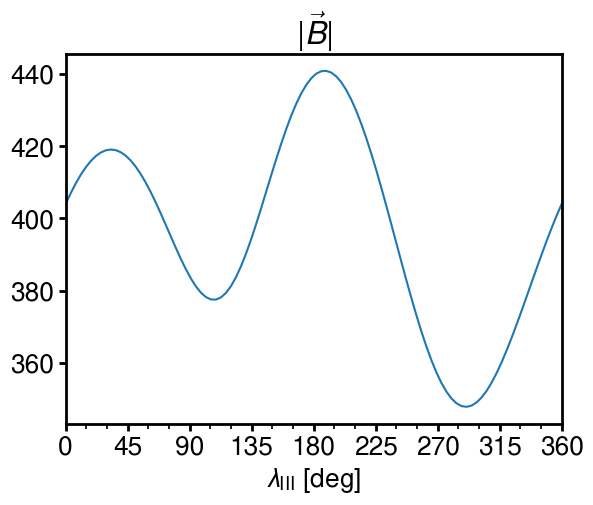

In [232]:
# 衛星公転軌道の磁場強度
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
S3lat = np.zeros(S3wlon.shape)                    # [rad]

theta_arr = 0.5*np.pi-S3lat
phi_arr = 2*np.pi-S3wlon

B = np.zeros(S3wlon.shape)
Br = np.zeros(S3wlon.shape)
Btheta = np.zeros(S3wlon.shape)
Bphi = np.zeros(S3wlon.shape)

x_arr = r_orbit*np.sin(theta_arr)*np.cos(phi_arr)
y_arr = r_orbit*np.sin(theta_arr)*np.sin(phi_arr)
z_arr = r_orbit*np.cos(theta_arr)

for i in range(S3wlon.size):
    theta = theta_arr[i]
    phi = phi_arr[i]
    x = x_arr[i]
    y = y_arr[i]
    z = z_arr[i]

    Bv = BJRM.B().JRM33(r_orbit, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]
    Br[i] = Bx*math.sin(theta)*math.cos(phi) \
        +By*math.sin(theta)*math.sin(phi) \
        +Bz*math.cos(theta)
    Btheta[i] = Bx*math.cos(theta)*math.cos(phi) \
        +By*math.cos(theta)*math.sin(phi) \
        -Bz*math.sin(theta)
    Bphi[i] = -Bx*math.sin(phi) + By*math.cos(phi)

    B[i] = B0

fig, ax = plt.subplots()
ax.set_title(r'$|\vec{B}|$')
ax.set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,361,45,dtype=int))
ax.set_xticklabels(np.arange(0,361,45,dtype=int))
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.plot(np.degrees(S3wlon), B*1E+9)

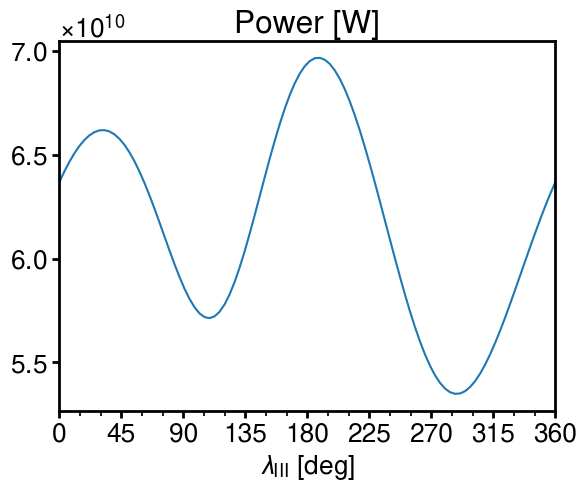

In [233]:
u = 100E+3         # 共回転速度 [m s-1]
rho = 2000         # プラズマ質量密度 [amu cm-3]
rho *= AMU*1E+6    # プラズマ質量密度 [kg m-3]

Sig_A = np.sqrt(rho/(MU0*(B**2)))
E_2 = (u**2)*(Btheta**2 + Br**2)

Pwr = 4*E_2*(RE**2)*Sig_A

fig, ax = plt.subplots()
ax.set_title(r'Power [W]')
ax.set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,361,45,dtype=int))
ax.set_xticklabels(np.arange(0,361,45,dtype=int))
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.yaxis.set_major_formatter(
        ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.plot(np.degrees(S3wlon), Pwr)

# リード角考慮 Power

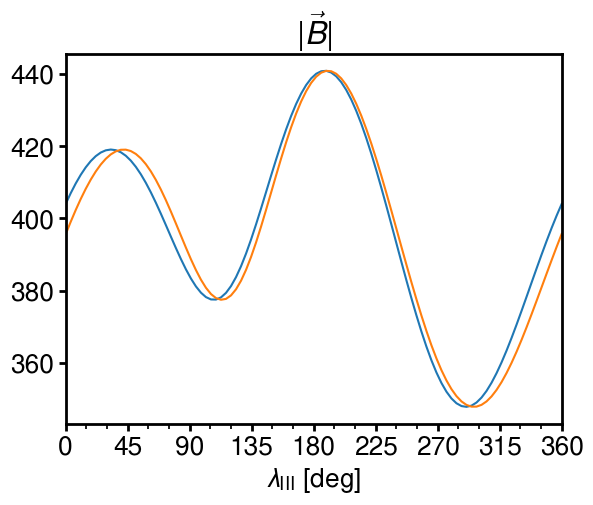

In [234]:
# 衛星公転軌道の磁場強度
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
S3lat = np.zeros(S3wlon.shape)                    # [rad]

theta_arr = 0.5*np.pi-S3lat
phi_arr = 2*np.pi-S3wlon

B = np.zeros(S3wlon.shape)
Br = np.zeros(S3wlon.shape)
Btheta = np.zeros(S3wlon.shape)
Bphi = np.zeros(S3wlon.shape)

x_arr = r_orbit*np.sin(theta_arr)*np.cos(phi_arr)
y_arr = r_orbit*np.sin(theta_arr)*np.sin(phi_arr)
z_arr = r_orbit*np.cos(theta_arr)

for i in range(S3wlon.size):
    theta = theta_arr[i]
    phi = phi_arr[i]
    x = x_arr[i]
    y = y_arr[i]
    z = z_arr[i]

    Bv = BJRM.B().JRM33(r_orbit, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]
    Br[i] = Bx*math.sin(theta)*math.cos(phi) \
        +By*math.sin(theta)*math.sin(phi) \
        +Bz*math.cos(theta)
    Btheta[i] = Bx*math.cos(theta)*math.cos(phi) \
        +By*math.cos(theta)*math.sin(phi) \
        -Bz*math.sin(theta)
    Bphi[i] = -Bx*math.sin(phi) + By*math.cos(phi)

    B[i] = B0

    # Br[i], Btheta[i], Bphi[i] = Bv[0], Bv[1], Bv[2]
    # B[i] = math.sqrt(Bv[0]**2 + Bv[1]**2 + Bv[2]**2)

# Hue+2023 fitting
delta = 5.78+3.29*np.cos(0.99*S3wlon)+1.42*np.sin(0.99*S3wlon)
lam3 = np.degrees(S3wlon)-delta
lam3 = np.radians(lam3)
phi_arr = 2*np.pi-lam3

B2 = np.zeros(S3wlon.shape)
Br2 = np.zeros(S3wlon.shape)
Btheta2 = np.zeros(S3wlon.shape)
Bphi2 = np.zeros(S3wlon.shape)

x_arr2 = r_orbit*np.sin(theta_arr)*np.cos(phi_arr)
y_arr2 = r_orbit*np.sin(theta_arr)*np.sin(phi_arr)
z_arr2 = r_orbit*np.cos(theta_arr)

for i in range(S3wlon.size):
    theta = theta_arr[i]
    phi = phi_arr[i]
    x = x_arr2[i]
    y = y_arr2[i]
    z = z_arr2[i]

    Bv = BJRM.B().JRM33(r_orbit, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]
    Br2[i] = Bx*math.sin(theta)*math.cos(phi) \
        +By*math.sin(theta)*math.sin(phi) \
        +Bz*math.cos(theta)
    Btheta2[i] = Bx*math.cos(theta)*math.cos(phi) \
        +By*math.cos(theta)*math.sin(phi) \
        -Bz*math.sin(theta)
    Bphi2[i] = -Bx*math.sin(phi) + By*math.cos(phi)

    B2[i] = B0

    # Br2[i], Btheta2[i], Bphi2[i] = Bv[0], Bv[1], Bv[2]
    # B2[i] = math.sqrt(Bv[0]**2 + Bv[1]**2 + Bv[2]**2)

fig, ax = plt.subplots()
ax.set_title(r'$|\vec{B}|$')
ax.set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,361,45,dtype=int))
ax.set_xticklabels(np.arange(0,361,45,dtype=int))
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.plot(np.degrees(S3wlon), B*1E+9)
ax.plot(np.degrees(S3wlon), B2*1E+9)

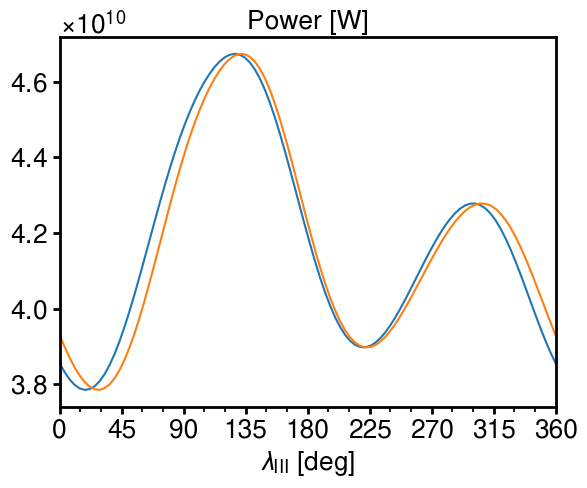

In [235]:
u = 100E+3         # 共回転速度 [m s-1]
Ai = 18            # イオン原子量 [amu]
Ti = 87            # イオン温度 [eV]
rho = 1207         # プラズマ質量密度 [amu cm-3]
rho *= AMU*1E+6    # プラズマ質量密度 [kg m-3]

# 質量密度の計算
# ダイポール座標系に持っていく
# S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
phiRH0 = math.radians(-155.8)    # Connerney+2020
rvec1 = np.array([
x_arr*math.cos(phiRH0) - y_arr*math.sin(phiRH0),
x_arr*math.sin(phiRH0) + y_arr*math.cos(phiRH0),
z_arr
])

# S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
THETA_D = math.radians(-6.7)
rvec1 = np.array([
rvec1[0]*math.cos(THETA_D) + rvec1[2]*math.sin(THETA_D),
rvec1[1],
-rvec1[0]*math.sin(THETA_D) + rvec1[2]*math.cos(THETA_D)
])

# 質量密度
H = 2.0*RJ
H0 = 0.64*RJ
H = H0*np.sqrt(Ti/Ai)
rho1 = rho*np.exp(-(rvec1[2]/H)**2)


# 質量密度の計算 - その2
# ダイポール座標系に持っていく
# S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
phiRH0 = math.radians(-155.8)    # Connerney+2020
rvec2 = np.array([
x_arr2*math.cos(phiRH0) - y_arr2*math.sin(phiRH0),
x_arr2*math.sin(phiRH0) + y_arr2*math.cos(phiRH0),
z_arr2
])

# S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
THETA_D = math.radians(-6.7)
rvec2 = np.array([
rvec2[0]*math.cos(THETA_D) + rvec2[2]*math.sin(THETA_D),
rvec2[1],
-rvec2[0]*math.sin(THETA_D) + rvec2[2]*math.cos(THETA_D)
])

# 質量密度
rho2 = rho*np.exp(-(rvec2[2]/H)**2)


# リード角考慮あり
Sig_A = np.sqrt(rho1/(MU0*(B**2)))
E_2 = (u**2)*(Btheta**2 + Br**2)
E_2 = (u**2)*(B**2)
Pwr = 4*E_2*(RE**2)*Sig_A

# リード角考慮なし
Sig_A2 = np.sqrt(rho2/(MU0*(B2**2)))
E2_2 = (u**2)*(Btheta2**2 + Br2**2)
E2_2 = (u**2)*(B2**2)
Pwr2 = 4*E2_2*(RE**2)*Sig_A2

fig, ax = plt.subplots()
ax.set_title(r'Power [W]', fontsize=19)
ax.set_xlabel(r'$\lambda_{\rm III}$ [deg]', fontsize=19)
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,361,45,dtype=int))
ax.set_xticklabels(np.arange(0,361,45,dtype=int))
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.yaxis.set_major_formatter(
        ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.plot(np.degrees(S3wlon), Pwr)
ax.plot(np.degrees(S3wlon), Pwr2)